In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import sys
sys.path.append('../src')
from data.audio_dataset import AudioSpectrogramDataset
from models.PGAN_model.PGAN import PGAN
from models.PGAN_model.config import *

import torch
import librosa
import soundfile as sf
from torch.utils.data import DataLoader

In [14]:
dataset = AudioSpectrogramDataset(base_directory=base_directory, spectro_type='mel', conditions_path=conditions_path)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [15]:
Music_PGAN = PGAN(
    latent_dim=latent_dim,
    output_dim=output_dim,
    lr=learning_rate,
    loss=loss,
    batch_size=batch_size,
    gpu=gpu,
    depths=depths, 
    negative_slope=negative_slope,
    fade_in_percentage=fade_in_percentage,
    save_interval=save_interval,
    normalization=normalization,
    mini_batch_normalization=mini_batch_normalization,
    epsilon_D=epsilon_D,
    gen_type=get_type,
    init_resolution_size=init_resolution_size,
    num_epochs_per_resolution=num_epochs_per_resolution,
    gen_output_dim=gen_output_dim,
    acgan=acgan,
    feature_size=feature_size,
    features_keys_order = features_keys_order
)

C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [16]:
Music_PGAN.train(dataloader=dataloader)

Resolution 0 - Epoch 1/200 - D Loss: 1.380053162574768 - G Loss: 0.6930409669876099
Resolution 0 - Epoch 2/200 - D Loss: 1.3681693077087402 - G Loss: 0.6929501295089722
Resolution 0 - Epoch 3/200 - D Loss: 1.3572189807891846 - G Loss: 0.6927970051765442
Resolution 0 - Epoch 4/200 - D Loss: 1.3450223207473755 - G Loss: 0.6925087571144104
Resolution 0 - Epoch 5/200 - D Loss: 1.332531452178955 - G Loss: 0.6922169923782349
Resolution 0 - Epoch 6/200 - D Loss: 1.3194551467895508 - G Loss: 0.6916686296463013
Resolution 0 - Epoch 7/200 - D Loss: 1.3048694133758545 - G Loss: 0.6908031105995178
Resolution 0 - Epoch 8/200 - D Loss: 1.2885884046554565 - G Loss: 0.6895095705986023
Resolution 0 - Epoch 9/200 - D Loss: 1.2699944972991943 - G Loss: 0.6875747442245483
Resolution 0 - Epoch 10/200 - D Loss: 1.2487179040908813 - G Loss: 0.6834268569946289
Resolution 0 - Epoch 11/200 - D Loss: 1.223301649093628 - G Loss: 0.6780843734741211
Resolution 0 - Epoch 12/200 - D Loss: 1.1948827505111694 - G Loss:

ValueError: value should be one of int, float, str, bool, or torch.Tensor

In [ ]:
# checkpoint_path = "../src/models/PGAN_model/checkpoints/PGAN_checkpoint_res1_epoch4.pth"
# Music_PGAN.train(dataloader=dataloader, checkpoint_path=checkpoint_path)

Resuming training from epoch 4 at resolution 1
Resolution 1 - Epoch 5/10 - D Loss: 0.26160770654678345 - G Loss: 0.7603479027748108
Resolution 1 - Epoch 6/10 - D Loss: 0.2303144931793213 - G Loss: 0.5080401301383972
Checkpoint saved: c:\0. Studia\0. Praca inzynierska\Music_Samples_Generator\src\models\PGAN_model\checkpoints\PGAN_checkpoint_res1_epoch6.pth
Resolution 1 - Epoch 7/10 - D Loss: 0.24150323867797852 - G Loss: 0.6541447043418884
Resolution 1 - Epoch 8/10 - D Loss: 0.2676298916339874 - G Loss: 0.8865568041801453
Checkpoint saved: c:\0. Studia\0. Praca inzynierska\Music_Samples_Generator\src\models\PGAN_model\checkpoints\PGAN_checkpoint_res1_epoch8.pth
Resolution 1 - Epoch 9/10 - D Loss: 0.203263521194458 - G Loss: 0.6860917806625366
Resolution 1 - Epoch 10/10 - D Loss: 0.23728398978710175 - G Loss: 0.6139963269233704
Checkpoint saved: c:\0. Studia\0. Praca inzynierska\Music_Samples_Generator\src\models\PGAN_model\checkpoints\PGAN_checkpoint_res1_epoch10.pth
Resolution 2 - Epoc

In [17]:
Music_PGAN.close_all_writers()

In [ ]:
# Music_PGAN.save_full_model("PGAN")

Full model saved: c:\0. Studia\0. Praca inzynierska\Music_Samples_Generator\src\models\PGAN_model\../../../models/saved_models/PGAN/PGAN


In [18]:
Music_PGAN.generator.eval()

PGenerator(
  (blocks): ModuleList(
    (0): ModuleList(
      (0): Sequential(
        (0): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2)
        (2): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): LeakyReLU(negative_slope=0.2)
      )
      (1): Sequential(
        (0): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (1): ModuleList(
      (0): Sequential(
        (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2)
        (2): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): LeakyReLU(negative_slope=0.2)
      )
      (1): Sequential(
        (0): ConvTranspose2d(128, 1, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (2): ModuleList(
      (0): Sequential(
        (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_spectrogram(spectrogram):
    fig, ax = plt.subplots()

    S_dB = librosa.amplitude_to_db(spectrogram, ref=np.min)
    img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=16000, ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title='PGAN generated mel-spectrogram')

In [20]:
bass_feature_vector = torch.zeros(1, 11)
keyboard_feature_vector = torch.zeros(1, 11)
bass_indices = [0]
keyboard_indices = [4]
bass_feature_vector[0, bass_indices] = 1
keyboard_feature_vector[0, keyboard_indices] = 1

In [21]:
def generate_spectrogram():

    bass_feature_vector = torch.zeros(1, 11)
    keyboard_feature_vector = torch.zeros(1, 11)
    bass_indices = [0]
    keyboard_indices = [4]
    bass_feature_vector[0, bass_indices] = 1
    keyboard_feature_vector[0, keyboard_indices] = 1

    bass_feature_vector = bass_feature_vector.view(1, 11, 1, 1).to(Music_PGAN.device)
    keyboard_feature_vector = keyboard_feature_vector.view(1, 11, 1, 1).to(Music_PGAN.device)

    z = torch.randn(1, Music_PGAN.latent_dim, 1, 1).to(Music_PGAN.device)
    if Music_PGAN.acgan:
        random_feature_vector = Music_PGAN.classification_criterion.create_random_feature_vectors(b_size=1)
        random_feature_vector = random_feature_vector.view(1, -1, 1, 1).to(Music_PGAN.device)
        z = torch.cat((z, random_feature_vector), dim=1)
        # z = torch.cat((z, bass_feature_vector), dim=1)
    generated_spectrogram = Music_PGAN.generator(z)

    spectrogram = generated_spectrogram.cpu().detach()
    spectrogram = spectrogram.squeeze()

    return spectrogram

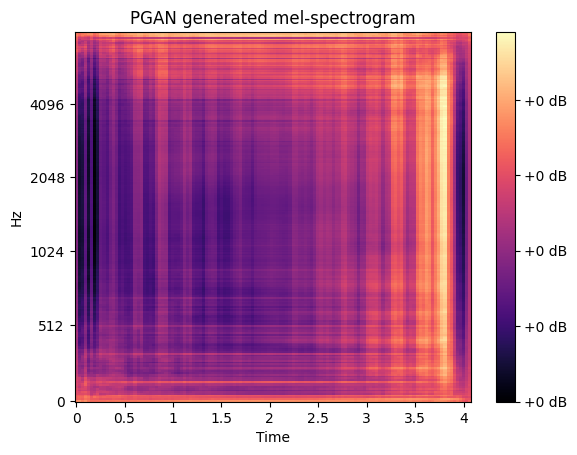

In [22]:
spectrogram = generate_spectrogram()
plot_spectrogram(spectrogram)

In [ ]:
audio = librosa.feature.inverse.mel_to_audio(spectrogram)

path = '../models/generated_samples/'
file_name = 'PGAN_generated_audio.wav'

sf.write(path + file_name, audio, 22050)